<a href="https://colab.research.google.com/github/adamggibbs/marine-carbonate-system-ml-prediction/blob/master/NN_development_framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML Model Training Pipeline 

This notebook contains a framework to train and test a neural network to estimate any ocean parameter from other specified ocean parameters given a data file in a standard oceanographic format referenced throughout this notebook (see the [data section](https://github.com/adamggibbs/marine-carbonate-system-ml-prediction/blob/master/README.md#data) of the README.md file for more info). The data used must be in the specified format and quality checked prior to using this notebook. Quick start intructions are below and more detailed instructions can be found in the development_README.md file within the GitHub repository: https://github.com/adamggibbs/marine-carbonate-system-ml-prediction. 

---

## Instructions
**Before using this notebook:**
1. Choose a location within your Google Drive to store all data and models
2. Run the [directory_setup.ipynb](https://github.com/adamggibbs/marine-carbonate-system-ml-prediction/blob/master/directory_setup.ipynb) Colab notebook to create the necessary directory structure for this notebook to run.
3. Place all training files you want to use for training in the **training directory** found under your **root directory**.
```
/My Drive/root_dir/data/training/
```
4. Place all training files you want to use for training in the **testing directory** found under your **root directory**.
```
/My Drive/root_dir/data/testing/
```
> **Note:** Training and testing files should be independent such that any data in the testing files should not be in the training files. 

**Before running this notebook:**
5.   Define all necessary user defined variables.
> **Note:** More details on the necessary user defined variables are in the cell below in this notebook and in `development_README.md` in the [GitHub repository](https://github.com/adamggibbs/marine-carbonate-system-ml-prediction).
6.   Define any optional user defined variables.
> **Note:** More details on optional user defined variables in `development_README.md` in the [GitHub repository](https://github.com/adamggibbs/marine-carbonate-system-ml-prediction).

**Running this notebook:**
> **Note** Ensure all necessary user defined variables are properly defined and data files in the proper format are uploaded in the training and testing directories

7. Run this notebook by navigating to the toolbar and selecting `Runtime -> Run all` or using `ctrl+F9`
8. When prompted, allow access to your Google Drive account by selecting **Connect to Google Drive**, then clicking on the Google Drive account you wish to use, and finally selecting **Continue** to finalize access.
> This allows only this specific Google Colab notebook to access your Google Drive files and will disconnect when the notebook is closed or a certain amount of idle time has passed.
9. The directory structure should be set up. Check your Google Drive to confirm. If the notebook does not work or throws an error, see the [Troubleshooting](#troubleshooting) section for help.
> Depending on the size of training and testing files and size of the neural network, this notebook can take over **1 hour to run and fully complete**. You can ensure progress is being made by following the logs produced by each cell in the notebook and the status bar at the bottom of the notebook. 
10. When complete this notebook will have trained and saved a neural network model directory:
```
#tensorflow data format
/My Drive/root_dir/models/model_name_Layers(...)/ 
# HDF5 data format
/My Drive/root_dir/models/model_name_Layers(...).h5
```
> To use the model to make estimations for your output variable with any data file file, use the [model_estimations.ipynb](https://github.com/adamggibbs/marine-carbonate-system-ml-prediction/blob/master/model_estimations.ipynb) notebook. This notebook will allow you to make estimations using any model you've trained on any data file in the specified format and add those estimations as a column to the data file. 

In [1]:
#@title # Set up environment.

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
import math
import copy
from sklearn.utils import shuffle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
import seaborn as sns
sns.set_color_codes(palette='colorblind')

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import metrics
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

Mounted at /content/drive


# Necessary User Defined Variables
Specify the user defined variables as followed:
- `root_dir_name`  [**String**] Name of the folder in Google Drive to store everything
- `model_name` [**String**] Name of the model for figures
- `input_vars` [**List**] The input variables to be used. The names must follow BGC Float data format (see `development_README.md` for list)
- `output_var` [**List**] The target variable to be estimated. The name must follow BGC Float data format (see `development_README.md` for list)
- `input_file_type` [**String**] Type of file to expect from training and testing files. 
> Should be either: `input_file_type = 'txt'`
or `input_file_type = 'csv'`
- `save_txt ` [**Boolean**] Whether to save copies of intermediate files as .txt files
- `save_csv`  [**Boolean**] Whether to save copies of intermediate files as .csv files
- `save_figs`  [**Boolean**] Whether to save evaluation figures as own files (they will also be saved in notebook, but will be lost if you reset the notebook)
- `show_figs`  [**Boolean**] Whether to show the figures produced in the notebook output as they are made

> **Note:** All values filled in are basic defaults

In [2]:
# name of folder in Google Drive 
# should be a relative path from 'My Drive' and end with trailing '/'
# exclude beginning '/'
root_dir_name = 'Example/'

# desired name of trained model
model_name = 'model_name'

# input variables
input_vars = ['DATE', 'LATITUDE', 'LONGITUDE', 'PRS', 'TMP', 'SAL', 'OXYGEN']
# output variable
output_var = 'PH_INSITU'

# what file type you're using,
# 'csv' for any comma separated value, 'txt' for any tab separated value
input_file_type = 'csv'

# save options for intermediate data files
# can save both or either .txt and .csv files
save_txt = False
save_csv = True

# display figures?
show_figs = True
# save figures?
save_figs = False

### Optional User Defined Variables

In [3]:
# reduce density (by)
reduce_density = False
density_reduction_factor = 10

# model hyperparams
# list of the hidden layers as the number of neurons they have
# MAKE A TUPLE!
model_layers = (48,24)
# list of activation functions of each layer
# if empty, all will be set to 'sigmoid'
# length of act_funcs must match length of model_layers
act_funcs = []

# model evaluation and fig settings
shallow = 200
d_label = "\n(Depths <{})".format(shallow)
m_col = 'b'
c_col = 'g'

# Training Pipeline

In [4]:
#@title ### Initialize directory variables.

# using specified root_dir_name, store paths to all necessary directories
root_dir = '/content/drive/MyDrive/'+ root_dir_name
print("Root Directory:" + root_dir)
model_dir = root_dir + 'models/'
print("Model Directory: " + model_dir)
fig_dir = root_dir + 'figs/'
print("Figures Directory: " + fig_dir)
data_dir = root_dir + 'data/'
print("Data Directory: " + data_dir)
training_dir=data_dir + 'training/'
print("Training Directory: " + training_dir)
testing_dir = data_dir + 'testing/'
print("Testing Directory: " + testing_dir)

Root Directory:/content/drive/MyDrive/Example/
Model Directory: /content/drive/MyDrive/Example/models/
Figures Directory: /content/drive/MyDrive/Example/figs/
Data Directory: /content/drive/MyDrive/Example/data/
Training Directory: /content/drive/MyDrive/Example/data/training/
Testing Directory: /content/drive/MyDrive/Example/data/testing/


In [5]:
#@title ### Initialize data cleaning preprocessing functions.

################################################################################
# FUNCTION TO READ DATA FILE IN A PANDAS DATAFRAME
def read_data_file(file):
  names = [ 'Cruise', 'Station', 'Type',	'DATE', 'TIME', 'LONGITUDE',	
         'LATITUDE',	'QF',	'PRS', 'PRS_QF', 'TMP', 'TMP_QF', 'SAL', 'SAL_QF', 
         'Sigma_theta', 'ST_QF', 'DEPTH', 'DEPTH_QF', 'OXYGEN', 'OXYGEN_QF',	
         'SATOXY',	'SATOXY_QF',	'NITRATE', 'NITRATE_QF', 'CHL_A', 'CHL_A_QF', 
         'BBP700', 'BBP700_QF', 'PH_INSITU', 'PH_INSITU_QF', 'BBP532', 
         'BBP_532_QF', 'CDOM', 'CDOM_QF', 'TALK_CANYONB', 'TALK_QF', 
         'DIC_CANYONB', 'DIC_QF', 'pCO2_CANYONB', 'pCO2_QF', 'SAT_AR_CANYONB', 
         'SAT_AR_QF', 'pH25C_1atm', 'pH25C_1atm_QF' ]

  if input_file_type == 'csv':
    df = pd.read_csv(file, header=0, sep=',')
  else:
    df = pd.read_csv(file, skiprows=7, header=None, sep='\t', names=names)
  
  df = df.dropna(axis=0, how='any').reset_index(drop=True)
  
  return df

################################################################################
# FUNCTION TO CREATE A NUMPY ARRAY OF INPUTS FROM DATA FILE
'''
process_data_file()
  description:
    This function reads in a data file in csv or txt format and
    creates a pandas dataframe from it. From there it loops through
    and removes all bad data points according to the quality control
    flags. It then takes the desired input parameters as sepcified in
    the 'Necessary User Defined Variables' cell and puts them into a 
    numpy array.

  args:
    file: string that contains file name of dataset
'''
def process_data_file(file, save_txt=False, save_csv=False):

  df = read_data_file(file)

  # decide data we care about
  relevant_vars = []
  # add input vars and their QFs
  for var in input_vars:
    relevant_vars.append(var)
    if var not in ['DATE', 'LATITUDE', 'LONGITUDE']:
      relevant_vars.append(var + '_QF')
  # add output var and its QF
  relevant_vars.append(output_var)
  relevant_vars.append(output_var + '_QF')  
  # take only data we care about
  df = df[relevant_vars]

  for input_var in input_vars:
      if input_var in ['DATE', 'LATITUDE', 'LONGITUDE']:
        continue
      # drop bad inputs
      index = 0
      to_drop = []
      for flag in df[input_var + '_QF']:
        if int(flag) > 0:
          to_drop.append(index)
        index += 1
      df = df.drop(to_drop).reset_index(drop=True)

  # drop bad outputs
  index = 0
  to_drop = []
  for flag in df[output_var + '_QF']:
    if int(flag) > 0:
      to_drop.append(index)
    index += 1
  df = df.drop(to_drop).reset_index(drop=True)

  # take subset of only parameters for inputs
  # this array contains only "good" data points
  inputs = df[input_vars]
  outputs = df[output_var]
  # convert dataframe in numpy array
  inputs = inputs.to_numpy(dtype='str')
  outputs = outputs.to_numpy(dtype='str')

  # CHANGE DATE FORMAT
  # find DATE index
  date_index = -1
  for i in range(0, len(input_vars)):
    if input_vars[i] == 'DATE':
      date_index = i
      break

  for row in inputs:
    date = row[date_index]
    row[date_index] = date[6:10] + date[0:2] + date[3:5]

  # TRANSFORM DATE AND PRESSURE INPUTS
  # method to help transform date
  def date_to_nth_day(the_date):
    date = pd.to_datetime(the_date)
    new_year_day = pd.Timestamp(year=date.year, month=1, day=1)
    day_of_the_year = (date - new_year_day).days + 1
    return day_of_the_year

  # loop through inputs and perform transformations
  for input in inputs:
    # adjust date
    date = input[date_index]
    frac_year = date_to_nth_day(date) / 365.0
    input[date_index] = int(date[0:4]) + frac_year 

  # return the array
  return inputs, outputs

# ################################################################################

# def prep_data(inputs, outputs):

#   # TRANSFORM DATE AND PRESSURE INPUTS

#   # method to help transform date
#   def date_to_nth_day(the_date):
#     date = pd.to_datetime(the_date)
#     new_year_day = pd.Timestamp(year=date.year, month=1, day=1)
#     day_of_the_year = (date - new_year_day).days + 1
#     return day_of_the_year

#   # loop through inputs and perform transformations
#   for input in inputs:
#     # adjust date
#     date = input[0]
#     frac_year = date_to_nth_day(date) / 365.0
#     input[0] = int(date[0:4]) + frac_year 
    
#   return inputs, outputs

In [6]:
#@title ### Load, clean, and preprocess data.

# create arrays to store train inputs and labels
train_input_arrays = []
train_output_arrays = []

print("Training directory contains the following training files:")
for file in os.listdir(training_dir):
  print(training_dir + file)

# for each file in our directory clean and preprocess data
print("\nBegin processing training files...")
for file in os.listdir(training_dir):
  print("Processing " + training_dir + file + " ... ", end="")

  curr_inputs, curr_outputs = process_data_file(training_dir+file)
  #curr_inputs, curr_outputs = prep_data(curr_inputs, curr_outputs)
  train_input_arrays.append(curr_inputs)
  train_output_arrays.append(curr_outputs)

  print("Complete.")

print("\nAll files successfully processed.\n")


print("Combining all data files, casting inputs and outputs as \
floating point numbers, and shuffling training points... ", end="")
# combine all arrays of inputs and labels
train_inputs = np.concatenate(train_input_arrays)
train_outputs = np.concatenate(train_output_arrays)

# convert all inputs and outputs to float type
train_inputs = train_inputs.astype('float')
train_outputs = train_outputs.astype('float')

# if we're reducing density, reduce it
if reduce_density:
  indices = range(0,train_outputs.shape[0],density_reduction_factor)
  train_inputs = np.take(train_inputs, indices, axis=0)
  train_outputs = np.take(train_outputs, indices, axis=0)

# shuffle training data
train_inputs, train_outputs = shuffle(train_inputs, train_outputs, 
                                      random_state=101)
print("Complete.")

print("\nTraining inputs and outputs successfully prepared for training.\n")
# display some metadata about training inputs and labels
print("Shape of training inputs: " + str(train_inputs.shape))
print("Shape of training outputs: " + str(train_outputs.shape))

num_print_rows = 5
print("First {} inputs:".format(num_print_rows))
print(train_inputs[0:num_print_rows])
print("First {} outputs:".format(num_print_rows))
print(train_outputs[0:num_print_rows])

Training directory contains the following training files:
/content/drive/MyDrive/Example/data/training/19A02901.csv
/content/drive/MyDrive/Example/data/training/20A02901.csv
/content/drive/MyDrive/Example/data/training/19702901.csv
/content/drive/MyDrive/Example/data/training/21202901.csv

Begin processing training files...
Processing /content/drive/MyDrive/Example/data/training/19A02901.csv ... Complete.
Processing /content/drive/MyDrive/Example/data/training/20A02901.csv ... Complete.
Processing /content/drive/MyDrive/Example/data/training/19702901.csv ... Complete.
Processing /content/drive/MyDrive/Example/data/training/21202901.csv ... Complete.

All files successfully processed.

Combining all data files, casting inputs and outputs as floating point numbers, and shuffling training points... Complete.

Training inputs and outputs successfully prepared for training.

Shape of training inputs: (82805, 7)
Shape of training outputs: (82805,)
First 5 inputs:
[[2021.28767123   36.796    

## Create and Train Model

In [7]:
#@title ### Build and compile model.
# METHOD TO BUILD AND COMPILE MODEL

# name of the model to save
model_save_name = model_name + "_Layers{}".format(model_layers)

#create model
model = keras.Sequential()

print("Creating and adding normalization layer... ", end="")
# create and add normalization layer
normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(train_inputs)
model.add(normalizer)
print("Complete.")

print("Creating and adding hidden layers... ", end="")
# add hidden layers
if len(act_funcs) == 0:
  for layer in model_layers:
    model.add(layers.Dense(layer, activation='sigmoid'))
else:
  for i in range(0, len(model_layers)):
    model.add(layers.Dense(model_layers[i], activation=act_funcs[i]))

# add final output layer
model.add(layers.Dense(1))
print("Complete.")

print("Compiling model...", end="")
# compile the model
model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=[ metrics.MeanAbsoluteError(),
                        metrics.MeanSquaredError(),
                        metrics.RootMeanSquaredError() ])
print("Complete.")

# Create model and display summary
print("\nModel Name: " + model_name)
model.summary()

Creating and adding normalization layer... Complete.
Creating and adding hidden layers... Complete.
Compiling model...Complete.

Model Name: model_name
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 7)                15        
 n)                                                              
                                                                 
 dense (Dense)               (None, 48)                384       
                                                                 
 dense_1 (Dense)             (None, 24)                1176      
                                                                 
 dense_2 (Dense)             (None, 1)                 25        
                                                                 
Total params: 1,600
Trainable params: 1,585
Non-trainable params: 15
_________________________________

Begin training model...

Epoch 1/100
2329/2329 [==============================] - 9s 3ms/step - loss: 1.5274 - mean_absolute_error: 0.4491 - mean_squared_error: 1.5274 - root_mean_squared_error: 1.2359 - val_loss: 0.0031 - val_mean_absolute_error: 0.0376 - val_mean_squared_error: 0.0031 - val_root_mean_squared_error: 0.0561
Epoch 2/100
2329/2329 [==============================] - 7s 3ms/step - loss: 0.0019 - mean_absolute_error: 0.0290 - mean_squared_error: 0.0019 - root_mean_squared_error: 0.0440 - val_loss: 0.0014 - val_mean_absolute_error: 0.0258 - val_mean_squared_error: 0.0014 - val_root_mean_squared_error: 0.0380
Epoch 3/100
2329/2329 [==============================] - 7s 3ms/step - loss: 0.0011 - mean_absolute_error: 0.0219 - mean_squared_error: 0.0011 - root_mean_squared_error: 0.0327 - val_loss: 8.5246e-04 - val_mean_absolute_error: 0.0194 - val_mean_squared_error: 8.5246e-04 - val_root_mean_squared_error: 0.0292
Epoch 4/100
2329/2329 [==============================] - 7s 3ms/

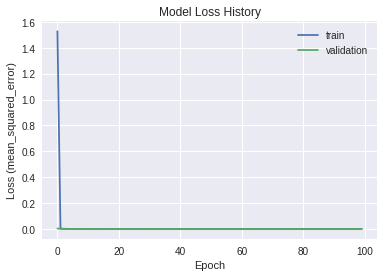

CPU times: user 13min 33s, sys: 1min 14s, total: 14min 47s
Wall time: 11min 52s


In [8]:
#@title ### Train model.

%%time

# train model
print("Begin training model...", end="\n\n")
history = model.fit(
    train_inputs, train_outputs,
    validation_split=0.1, epochs=100,
    use_multiprocessing=True)
print("Training complete.")

# save model in tf standard format and HDF5 format
model.save(model_dir + model_name)
model.save(model_dir + model_name + ".h5")

# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss History')
plt.ylabel('Loss (mean_squared_error)')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


In [ ]:
#@title # Visualize Accuracy on Training Set

test_predictions = model.predict(train_inputs).flatten()

ax = plt.axes(aspect='equal')

plt.scatter(train_outputs, test_predictions)

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
plt.ylim(lims)
plt.xlim(lims)
plt.plot(lims,lims, color='black')

plt.title('pH Predictions vs Observations')
plt.xlabel('True Values pH')
plt.ylabel('Predictions pH')

plt.show()

# Model Evaluation

In [ ]:
#@title # Get Testing Data
test_input_arrays = []
test_output_arrays = []

for file in os.listdir(testing_dir):
  display(testing_dir+file)

  curr_inputs, curr_outputs = process_data_file(testing_dir+file)
  curr_inputs, curr_outputs = prep_data(curr_inputs, curr_outputs)
  test_input_arrays.append(curr_inputs)
  test_output_arrays.append(curr_outputs)

test_inputs = np.concatenate(test_input_arrays)
test_outputs = np.concatenate(test_output_arrays)

test_inputs = test_inputs.astype('float')
test_outputs = test_outputs.astype('float')

display(test_inputs.shape)
display(test_outputs.shape)

In [ ]:
#@title # Depth Conversion

# FUNCTION: CONVERT PRESSURE TO DEPTH
# Python version of the following MATLAB function
'''
% SW_DPTH    Depth from pressure
%===========================================================================
% SW_DPTH   $Id: sw_dpth.m,v 1.1 2003/12/12 04:23:22 pen078 Exp $
%           Copyright (C) CSIRO, Phil Morgan 1992.
%
% USAGE:  dpth = sw_dpth(P,LAT)
%
% DESCRIPTION:
%    Calculates depth in metres from pressure in dbars.
%
% INPUT:  (all must have same dimensions)
%   P   = Pressure    [db]
%   LAT = Latitude in decimal degress north [-90..+90]
%         (lat may have dimensions 1x1 or 1xn where P(mxn).
%
% OUTPUT:
%  dpth = depth [metres]
%
% AUTHOR:  Phil Morgan 92-04-06  (morgan@ml.csiro.au)
%
% DISCLAIMER:
%   This software is provided "as is" without warranty of any kind.
%   See the file sw_copy.m for conditions of use and licence.
%
% REFERENCES:
%    Unesco 1983. Algorithms for computation of fundamental properties of
%    seawater, 1983. _Unesco Tech. Pap. in Mar. Sci._, No. 44, 53 pp.
%=========================================================================
'''
def pres_to_depth(pres, lat):

  # define constants
  DEG2RAD = math.pi/180
  c1 = 9.72659
  c2 = -2.2512E-5
  c3 = 2.279E-10
  c4 = -1.82E-15
  gam_dash = 2.184E-6

  # convert latitude
  LAT = abs(lat)
  X = math.sin(LAT*DEG2RAD)
  X = X*X

  # calculate denomenator and numerator
  denom = 9.780318*(1.0+(5.2788E-3 + 2.36E-5*X)*X) + gam_dash*0.5*pres 
  numer = (((c4 * pres + c3) * pres + c2) * pres + c1) * pres

  # return quotient
  return numer / denom


# FUNCTION: CONVERT ARRAY OF INPUTS TO AN ARRAY OF DEPTHS
def get_depths(input_arr):
  # create numpy array to store depths
  depths = np.zeros(len(input_arr))
  # loop through inputs and calculate depth
  ind = 0
  for input in input_arr:
    depths[ind] = pres_to_depth(input[3], input[1])
    ind += 1
  # return depth array
  return depths


# get depths from inputs
test_depths = get_depths(test_inputs)

In [ ]:
#@title # Make Predictions

# make predictions on testing dataset with neural network
test_predictions = model.predict(test_inputs, verbose=1).flatten()

# GET DATAPOINTS FROM SHALLOW DEPTHS (<200m)
# loop through depths and get indices of deep datapoints 
ind = 0
inds = []
for depth in test_depths:
  if depth > shallow:
    inds.append(ind)
  ind += 1

# delete deep datapoints and store resulting array of shallow datapoints
shallow_test_depths = np.delete(test_depths, inds, axis=0)
shallow_test_predictions = np.delete(test_predictions, inds, axis =0)
shallow_outputs = np.delete(test_outputs, inds, axis=0)

# ensure there are no deep datapoints
count = 0
for depth in shallow_test_depths:
  if depth > shallow:
    count += 1
print('Number of datapoints of depth greater than {}m: {}'.format(shallow, count))

print('Shape of each shallow data array (all should be equal):')
display(shallow_test_depths.shape)
display(shallow_test_predictions.shape)
display(shallow_outputs.shape)

## Error Metrics
### MAE, MSE, RMSE

In [ ]:
#@title ### Error metrics table. 
# TEST INITIAL PERFORMANCE ON TRAINING, VALIDATION, & TESTING SETS

model_metrics = np.zeros((1,6))

# get metrics for DNN
mae = mean_absolute_error(test_outputs, test_predictions)
mse = mean_squared_error(test_outputs, test_predictions)
rmse = math.sqrt(mse)
# round metrics to 5 decimal places
model_metrics[0][0] = np.round(mae, 5)
model_metrics[0][1] = np.round(mse, 5)
model_metrics[0][2] = np.round(rmse, 5)
# get metrics for DNN
s_mae = mean_absolute_error(shallow_outputs, shallow_test_predictions)
s_mse = mean_squared_error(shallow_outputs, shallow_test_predictions)
s_rmse = math.sqrt(s_mse)
# round metrics to 5 decimal places
model_metrics[0][3] = np.round(s_mae, 5)
model_metrics[0][4] = np.round(s_mse, 5)
model_metrics[0][5] = np.round(s_rmse, 5)

# create table
# labels for columns and rows
col_labels = ['MAE', 'MSE', 'RMSE', 'S-MAE*', 'S-MSE*', 'S-RMSE*']
row_labels = [model_name]

# add data to table
fig, ax = plt.subplots(1, figsize=(10,3.5))
table = ax.table(cellText=model_metrics, cellLoc='center', loc='center', 
                 rowLabels=row_labels, colLabels=col_labels)
# title plot
fig.suptitle('Error Metrics',
             ha='center', va='center', fontsize=20, weight='bold')
# scale plot
table.set_fontsize(15)
table.scale(1,4)
ax.axis('off')

plt.text(1,0, "* \"S-\" denotes \"Shallow\" which specifies depths less than 200m",
         ha='right', fontsize=12)

plt.tight_layout()

# save and show plot
if save_figs:
  plt.savefig(fig_dir+'combined_err_metrics.png', bbox_inches='tight')
if show_figs:
  plt.show()

## Estimates vs Observations 1-1 Plots

In [ ]:
plt.rcParams["axes.edgecolor"] = "white"
plt.rcParams["axes.linewidth"]  = 0

In [ ]:
#@title ### For overall dataset, plot predictions vs observations.

fig, ax1 = plt.subplots(1, 1, figsize=(10,5), sharey=True)
ax1.set_aspect('equal')

# plot scatter plots of estimations vs observations
# (x=observations, y=estimations, blue=our DNN, red=CANYON-B)
ax1.scatter(test_outputs, test_predictions, label=model_name,
            color=m_col, s=10, alpha=0.1)


ax1.set_xlabel('pH Measured')
ax1.xaxis.label.set_size(14)
ax1.set_ylabel('pH Estimated')
ax1.yaxis.label.set_size(14)

# get axis limits from min and max ofdata
lims = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
]

ax1.plot(lims,lims, color='k')
ax1.set_ylim(lims)
ax1.set_xlim(lims)

# title, label, and legend plot
fig.suptitle('pH Estimations vs Observations\n', y=1,
             va='center', fontsize=18, weight='bold')
ax1.set_title(model_name, fontsize=16, weight='bold')

plt.tight_layout()

# show plot
if save_figs:
  plt.tight_layout()
  plt.savefig(fig_dir+'est_v_obs.png', bbox_inches='tight')
if show_figs:
  plt.show()


In [ ]:
#@title ### For shallow dataset, plot predictions vs observations.
fig, ax1 = plt.subplots(1, 1, figsize=(10,5), sharey=True)
ax1.set_aspect('equal')

# plot scatter plots of estimations vs observations
# (x=observations, y=estimations, blue=our DNN, red=CANYON-B)
ax1.scatter(shallow_outputs, shallow_test_predictions, label=model_name,
            color=m_col, s=10, alpha=0.1)

ax1.set_xlabel('pH Measured')
ax1.xaxis.label.set_size(14)
ax1.set_ylabel('pH Estimated')
ax1.yaxis.label.set_size(14)

# get axis limits from min and max ofdata
lims = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
]

ax1.plot(lims,lims, color='black')
ax1.set_ylim(lims)
ax1.set_xlim(lims)

# title, label, and legend plot
fig.suptitle('pH Estimations vs Observations' + d_label, y=1.025,
             va='center', fontsize=18, weight='bold')
ax1.set_title(model_name, fontsize=16, weight='bold')

plt.tight_layout()

# show plot
if save_figs:
  plt.savefig(fig_dir+'est_v_obs_shallow.png', bbox_inches='tight')
if show_figs:
  plt.show()


## Depth vs Error Plots

In [ ]:
#@title ### Plot error vs depth for overall dataset.
# get errors (estimations - observations)
error = test_predictions - test_outputs

fig, ax = plt.subplots(1, figsize=(10,11))

# plot the scatter plots
ax.scatter(error, test_depths, label=model_name, 
           color=m_col, s=10, alpha=0.1)

# place a vertical line at x=0 to represent error=0
ax.axvline(x=0, color='black')
# invert y-axis to better represent depth
ax.invert_yaxis()
ax.set_xlabel('pH Error (Est - Obs)')
ax.xaxis.label.set_size(14)
ax.set_ylabel('Depth (m)')
ax.yaxis.label.set_size(14)

# label plot
fig.suptitle('pH Error vs Depth', y=1.025,
             fontsize=20, weight='bold')
ax.set_title(model_name, fontsize=16, weight='bold')

plt.tight_layout()

# show plot
if save_figs:
  plt.savefig(fig_dir+'err_v_depth.png', bbox_inches='tight')
if show_figs:
  plt.show()


In [ ]:
#@title ### Plot Error vs depth for shallow dataset.
# get errors (estimations - observations)
shallow_error = shallow_test_predictions - shallow_outputs

fig, ax = plt.subplots(figsize=(10,10))

# plot the scatter plots
ax.scatter(shallow_error, shallow_test_depths, label=model_name, 
           color=m_col, s=10, alpha=0.1)

# place a vertical line at x=0 to represent error=0
ax.axvline(x=0, color='black')
# invert y-axis to better represent depth
ax.invert_yaxis()
ax.set_xlabel('pH Error (Est - Obs)')
ax.xaxis.label.set_size(14)
ax.set_ylabel('Depth (m)')
ax.yaxis.label.set_size(14)

# label plot
fig.suptitle('pH Error vs Depth' + d_label, y=1.025,
             va='center', fontsize=20, weight='bold')
ax.set_title(model_name, fontsize=16, weight='bold')

plt.tight_layout()

# save and show plot
if save_figs:
  plt.savefig(fig_dir+'err_v_depth_shallow.png', bbox_inches='tight')
if show_figs:
  plt.show()


## Heatmaps

In [ ]:
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"]  = 2

In [ ]:
#@title ### Plot heatmap for error vs depth for overall dataset.

fig, ax1 = plt.subplots(1, figsize=(10,10))

ranges = [[-0.1, 0.1],
          [0, 1000]]

hh1 = ax1.hist2d(error, test_depths, 
                 range=ranges, bins=(150,100), cmap=plt.cm.plasma)
ax1.invert_yaxis()
ax1.axvline(x=0, color='w')
fig.colorbar(hh1[3], ax=ax1)

fig.suptitle('Heatmap of Error vs Depth', y=1.025,
             ha='center', va='center', fontsize=20, weight='bold')
ax1.set_title(model_name, fontsize=18, weight='bold')

ax1.set_xlabel('pH Error (Est - Obs)')
ax1.xaxis.label.set_size(16)
ax1.set_ylabel('Depth (m)')
ax1.yaxis.label.set_size(16)

plt.tight_layout()

if save_figs:
  plt.savefig(fig_dir + 'err_v_depth_heatmap.png', bbox_inches='tight')
if show_figs:
  plt.show()

In [ ]:
#@title ### Plot heatmap for error vs depth for shallow dataset.
fig, ax1 = plt.subplots(1, figsize=(10,10))

ranges = [[-0.1, 0.1],
          [0,shallow]]

hh1 = ax1.hist2d(shallow_error, shallow_test_depths, 
                 range=ranges, bins=(150,100), cmap=plt.cm.plasma)
ax1.invert_yaxis()
ax1.axvline(x=0, color='w')
fig.colorbar(hh1[3], ax=ax1)

fig.suptitle('Heatmap of Error vs Depth' + d_label, y=1.025,
             ha='center', va='center', fontsize=20, weight='bold')
ax1.set_title(model_name, fontsize=18, weight='bold')

ax1.set_xlabel('pH Error (Est - Obs)')
ax1.set_ylabel('Depth (m)')

plt.tight_layout()

if save_figs:
  plt.savefig(fig_dir+'err_v_depth_heatmap_shallow.png', bbox_inches='tight')
if show_figs:
  plt.show()

# Conclusion

In [ ]:
#@title # Finish notebook.
print("Notebook complete.")